In [3]:
from prepare_data.trend_utils import Segment, Gaussignal
from prepare_data.conts_predtrend import WIND_SED, RATIO, DEPTH, PREDICT_LAG
from prepare_data.constants import FUTURE, GLASS_COLS, MAIN_COLS
from prepare_data.utils import csv2df, clean_dataset, split_sequence
# Нормировщики
from sklearn.preprocessing import MinMaxScaler
import numpy as np # библиотека нампи
import joblib
# Нормировщики
from sklearn.preprocessing import MinMaxScaler

In [4]:
path = "./stock_data/BTCUSDT_1 _min.csv"
df_data = csv2df(path)
df_data = clean_dataset(df_data)


dataset = df_data[:FUTURE]
print(f'Размер изучаемых данных {dataset.shape}')

Размер изучаемых данных (2800, 54)


C:\Users\greta\AppData\Local\Temp\ipykernel_3524\1381659372.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Trend'] = seg.get_segmented(dataset, wind = WIND_SED, ratio = RATIO)


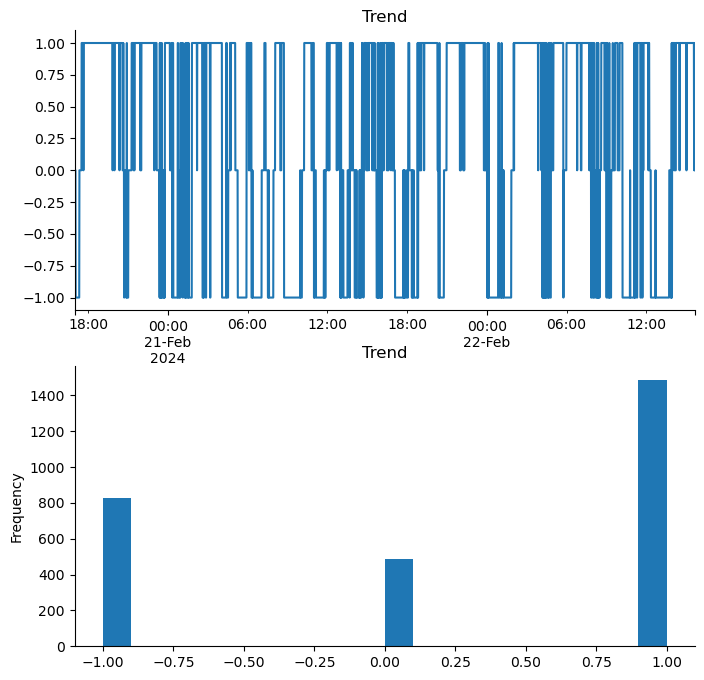

In [5]:
seg = Segment()
dataset['Trend'] = seg.get_segmented(dataset, wind = WIND_SED, ratio = RATIO)
seg.plot_segmented(dataset['Trend'])

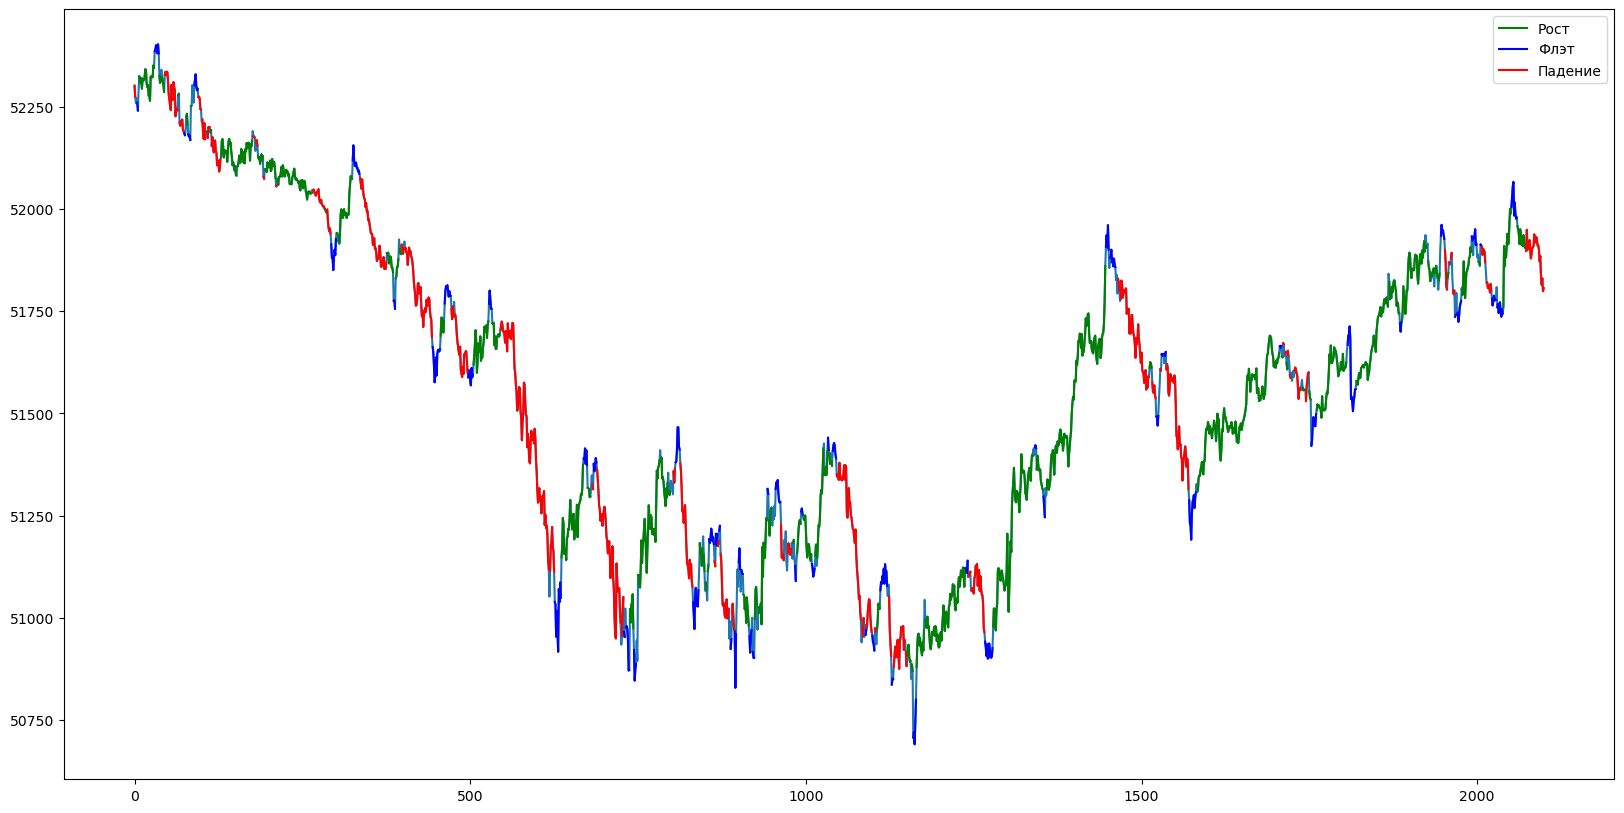

In [6]:
start = 400  # начало фрагмента
end = 2500 #all_data.shape[0]    # окончание фрагмента
seg.plot_trend(dataset, start, end)

# Формируем первичные X, Y данные

In [11]:
# колонки для тренировочной выборки
TRAIN_COLUMNS = MAIN_COLS + GLASS_COLS
GLASS = len(GLASS_COLS)
VAL_LEN = 500                                           # Объем валидационной выборки

# создаем X данные
x_data = dataset[TRAIN_COLUMNS].to_numpy()

# создаем данные классов ответов
y_data = dataset["Trend"]


## to gaus signal

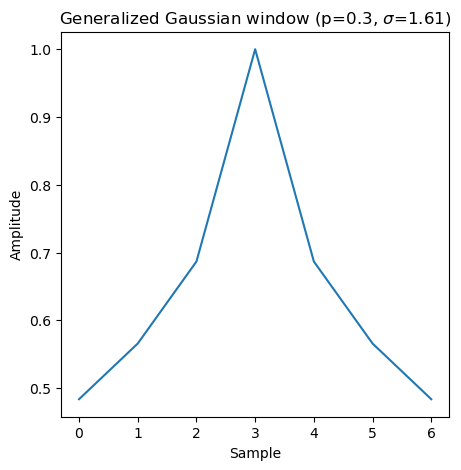

In [8]:
gd = Gaussignal(y_data)
gd.plot_signal()

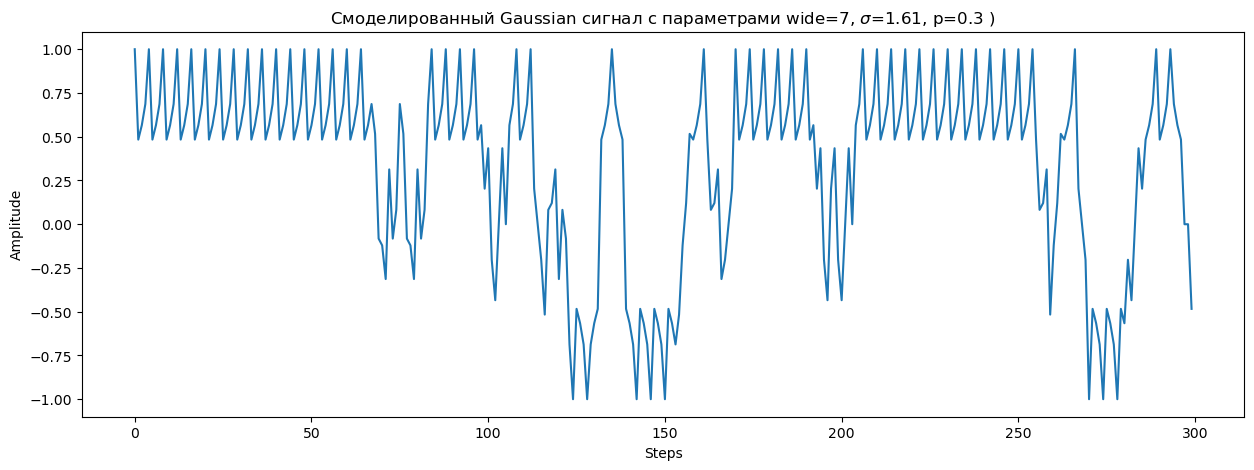

In [9]:
gd.plot_gausdata(100, 400, gd.regress_signal)

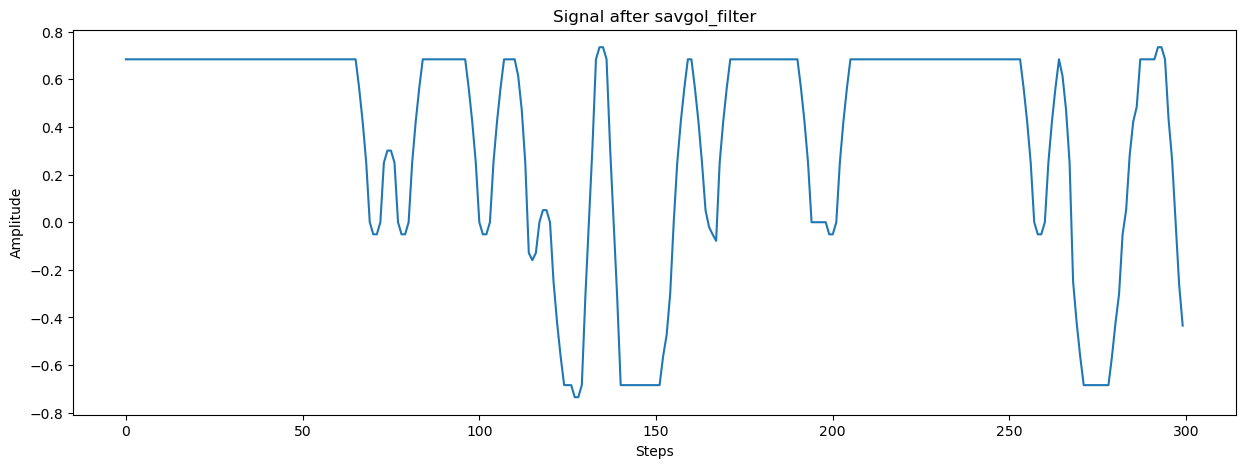

In [10]:
gd.plot_gausdata(100, 400, gd.filtered_signal, title = "Signal after savgol_filter")

In [17]:
train_x, train_y = x_data[:-VAL_LEN-DEPTH], gd.filtered_signal[:-VAL_LEN-DEPTH]
val_x, val_y = x_data[-VAL_LEN:], gd.regress_signal[-VAL_LEN:]

print('train_data: ', train_x.shape, train_y.shape,
      '\nval_data:  ', val_x.shape, val_y.shape,
      '\nОбщая длина:', train_x.shape[0] + val_x.shape[0])


train_data:  (2268, 54) (2268,) 
val_data:   (500, 54) (500,) 
Общая длина: 2768


# Масштабирование входных данных

In [18]:
# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
X_MAIN_SCALER = MinMaxScaler(feature_range = (0, 1)) #  RobustScaler() # StandardScaler() #
X_MAIN_SCALER.fit(train_x[:,:-GLASS])                  # обучаем X_SCAILER

X_GLASS_SCALER = MinMaxScaler(feature_range = (0, 1)) #  RobustScaler() # StandardScaler() #
X_GLASS_SCALER.fit(train_x[:,-GLASS:])                  # обучаем X_SCAILER

x_train_sc = np.zeros_like(train_x)
x_val_sc = np.zeros_like(val_x)

x_train_sc[:,:-GLASS] = X_MAIN_SCALER.transform(train_x[:,:-GLASS])  # трансформируем x_train
x_val_sc[:,:-GLASS] = X_MAIN_SCALER.transform(val_x[:,:-GLASS])      # трансформируем x_val

x_train_sc[:,-GLASS:] = X_GLASS_SCALER.transform(train_x[:, -GLASS:])  # трансформируем x_train
x_val_sc[:,-GLASS:] = X_GLASS_SCALER.transform(val_x[:, -GLASS:])      # трансформируем x_val

print(x_train_sc.shape, x_val_sc.shape)
x_train_sc[0], x_val_sc[0]

(2268, 54) (500, 54)


(array([0.40302501, 0.36919479, 0.24646382, 0.27367042, 0.90124226,
        0.1325406 , 0.14948609, 0.47508019, 0.65613952, 0.53963351,
        0.23672043, 0.24424779, 0.24528302, 0.75471698, 0.29556962,
        0.33008526, 0.66991474, 0.29540912, 0.12951434, 0.08434592,
        0.54727759, 0.00911167, 0.06993288, 0.02108606, 0.01222567,
        0.00363639, 0.        , 0.01680848, 0.02392322, 0.04781827,
        0.00690962, 0.11219   , 0.03048325, 0.03112567, 0.0214175 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.05521034]),
 array([0.65632849, 0.63887961, 0.68769716, 0.65277929, 0.07644321,
        0.79930394, 0.07638734, 0.06158472, 0.07005245, 0.14512791,
        0.24025935, 0.80530973, 0.81132075, 0.18867925, 0.52278481,
        0.56272838, 0.43727162, 0.43967131, 0.108563  , 0.

# Формирование выборок для нейросети

In [19]:
# Формирование выборок для обучения нейросети
x_train_sc, y_train_sc = split_sequence(x_train_sc, train_y, DEPTH, PREDICT_LAG)
x_val_sc, y_val_sc = split_sequence(x_val_sc, val_y, DEPTH, PREDICT_LAG)

# Проверка результата
print('Массивы x_train и y_train:\t', x_train_sc.shape, y_train_sc.shape)
print('Массивы x_val и y_val:\t', x_val_sc.shape, y_val_sc.shape)

Массивы x_train и y_train:	 (2232, 32, 54) (2232, 5)
Массивы x_val и y_val:	 (464, 32, 54) (464, 5)


## save data

In [22]:
joblib.dump(X_MAIN_SCALER, './predtrend/x_main_scailer.save') 
joblib.dump(X_GLASS_SCALER, './predtrend/x_glass_scailer.save') 
np.save('./predtrend/x_train_sc.npy', x_train_sc) 
np.save('./predtrend/x_val_sc.npy', x_val_sc) 
np.save('./predtrend/y_train_sc.npy', y_train_sc) 
np.save('./predtrend/y_val_sc.npy', y_val_sc) 
np.save('./predtrend/y_data.npy', y_data.to_numpy()) 
y_data

Datetime
2024-02-20 17:00:00   -1
2024-02-20 17:01:00    0
2024-02-20 17:02:00    0
2024-02-20 17:03:00    0
2024-02-20 17:04:00   -1
                      ..
2024-02-22 15:35:00    1
2024-02-22 15:36:00    0
2024-02-22 15:37:00    1
2024-02-22 15:38:00    0
2024-02-22 15:39:00    0
Name: Trend, Length: 2800, dtype: int64